In [1]:
!pip install -q 'git+https://github.com/sarah-keren/multi-taxi'

ERROR: Invalid requirement: "'git+https://github.com/sarah-keren/multi-taxi'"


# Our Problem
The problem that we will focus on today is to make a taxi move towards a single passenger and to pick it up, without dropping it at its destination.

![Taxi_domain_show](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Taxi_domain_show.png)

The only guidance that we will provide to our agent is a **reward function** that prizes the agent for picking up the passenger and that penalizes the agent for taking too many steps to reach the goal.

In particular, the reward function is defined as follows:
- +100 points for a successful drop-off
- -5 point for every bad pick-up
- -2 points for hitting an obstacle (e.g. a wall)
- -1 for every step taken

In [1]:
from multi_taxi import Event

customized_reward = {
    Event.PICKUP: 100,
    Event.BAD_PICKUP: -5,
    Event.HIT_OBSTACLE: -2,
    Event.STEP: -1
}

# Our Tools
In our case we are **not** given access to a model, i.e. we don't know the transition function $ T: \mathcal{S} \times \mathcal{A} \rightarrow \mathcal{S} $ and the reward function $ R: \mathcal{S} \times \mathcal{A} \rightarrow \mathcal{S} $, where $\mathcal{S}$ is the set of states and $\mathcal{A}$ is the set of actions. 

We can only interact with the environment by taking actions and observing the resulting state and reward.
This approach is thus based on Monte Carlo simulations and it is called **model-free**.

## Monte Carlo Simulation
To understand how Monte Carlo simulations work, let's see it in action.
First, we will create a helper function which will allow us to create an environment by specifying the position of the taxi and the passenger.

In [2]:
from multi_taxi import multi_taxi_v0
from multi_taxi.world.maps import DEFAULT_MAP, BIG_MAP

def new_environment_creator(taxi_pos, passenger_pos, 
                            num_taxis=1,num_passengers=1, 
                            pickup_only=True, can_see_other_taxi_info=False, 
                            domain_map=DEFAULT_MAP,reward_table=customized_reward):
    """
    A helper function to setup a new environment with predefined taxi and passenger locations
    :param taxi_pos: The location of the taxi
    :param passenger_pos: The location of the passenger
    :param num_taxis: The number of taxis in the environment (default: 1)
    :param num_passengers: The number of passengers in the environment (default: 1)
    :param pickup_only: Whether the passenger can be dropped off or not (default: True)
    :param can_see_other_taxi_info: Whether the taxi can see the other taxis' locations (default: False)
    :param domain_map: The map of the environment (default: DEFAULT_MAP)
    :param reward_table: The reward table of the environment (default: customized_reward)
    :return: The new environment
    """
    new_env = multi_taxi_v0.env(num_taxis=num_taxis, num_passengers=num_passengers, pickup_only=pickup_only, domain_map=domain_map,
                                can_see_other_taxi_info=can_see_other_taxi_info,reward_table=reward_table, 
                                render_mode='human', allow_arrived_passengers_on_reset=False)
    new_env.reset()

    state = new_env.state()
    state.taxis[0].location = taxi_pos
    state.passengers[0].location = passenger_pos
    new_env.unwrapped.set_state(state)

    return new_env


# Create the environment from which we will run the Monte Carlo Simulations
taxi_position = (0,0)
passenger_position = (3,3)
env = new_environment_creator(taxi_position, passenger_position)

Next, we will create a function that will allow us to simulate a single episode, i.e. a single run of the environment, by taking random actions until the episode ends.

In [3]:
import numpy as np
from IPython.display import clear_output
from copy import deepcopy

def run_monte_carlo_simulation(environment, gamma, max_number_of_steps: int =100_000, verbose: bool = False, render: bool = False):
    """
    Runs a Monte Carlo simulation on a given environment
    :param environment: The environment on which to run the simulation
    :param gamma: The discount factor
    :param max_number_of_steps: The maximum number of steps to run the simulation for (default: 100_000)
    :param verbose: Whether to print the results of the simulation (default: False)
    :param render: Whether to render the environment (default: False)
    :return: The accumulated reward
    """
    # Copy the environment so we don't change the original
    env = deepcopy(environment)

    number_of_actions = len(env.unwrapped.get_action_map('taxi_0').values())
    accumulated_reward = 0
    # Run the simulation for at most max_number_of_steps steps
    for step in range(max_number_of_steps):
        # Choose a random action
        action = np.random.choice(number_of_actions)
        # Take the action
        env.step(action)
        # Get the last state
        obs, reward, done, trunc, info = env.last()
        # Accumulate the reward
        accumulated_reward += reward * (gamma ** step)
        if render:
            clear_output(wait=True)
            if verbose:
                print(f"Step {step}: Accumulated reward: {accumulated_reward}")
            env.render()
        # If the simulation is done, stop
        if done:
            break
    del env

    return accumulated_reward

Now we are ready to simulate a single episode.

Try to run the next cell multiple times and see what happens.

In [4]:
GAMMA = 1.0
run_monte_carlo_simulation(env, gamma=GAMMA, render=True, verbose=True)

Step 138: Accumulated reward: -214.0
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 139, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



-214.0

It is possible to notice that some simulations are really long and some are short. This shows the **variance** to which Monte Carlo simulations are exposed. This variance will be propagated to our estimates and it is the reason why we will need to run many Monte Carlo simulations to obtain a good estimate.

Another important thing that we need to pay attention to is the impact of the **discount factor** $\gamma$. Try to see what happens as you lower the value of $\gamma$.

Run the next cell multiple times and see what happens.

In [5]:
GAMMA = 0.70
run_monte_carlo_simulation(env, gamma=GAMMA, render=True, verbose=True)

Step 528: Accumulated reward: -7.384256467457955
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 529, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



-7.384256467457955

As you can see, with a **lower value** of $\gamma$ the actions taken after a **high number of steps** have a very **limited impact** on the accumulated reward. This is because the reward is discounted by a factor of $\gamma$ at each step. For this reason, the agent will care less about the actions taken after a high number of steps, limiting the horizon of its planning. For example, the agent will not care too much if it reached the passenger in 1_000 steps or in 1_100 steps. This will lead to a more **short-sighted** behaviour. 

More importantly, it will lower the variance of our estimates, requiring less Monte Carlo simulations to converge.

Now we will see how to use Monte Carlo simulations to solve our problem.

# Monte Carlo Control

The most immediate way to exploit Monte Carlo simulations to solve our problem is to use them to estimate the **q-value function** $Q(s,a)$, i.e. the expected reward that we will get by executing action $a$ in the state $s$.

## Algorithm Structure
Monte Carlo Control follows the paradigm of Generalised Policy Iteration (GPI), which is composed of two main steps:
1. **Policy Evaluation** (Monte Carlo Estimation for Action Values):
   - Use Monte Carlo simulations to estimate $Q(s,a)$
2. **Policy Improvement** (Greedy Policy Improvement):
   - Improve the policy $\pi$ by acting greedily with respect to $Q(s,a)$
3. Repeat until convergence

![monte_carlo_control_schema](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Monte_Carlo_Control_small.png)

On top of this basic algorithm, we will add a **decaying $\epsilon$-greedy policy** to allow the agent to explore the environment.

Here is the complete algorithm:

P.S. Ignore the line "Unless the pair $S_t, A_t$ appears in $S_0, A_0, S_1, A_1, ..., S_{t-1}, A_{t-1}$". This is just a technicality that can be ignored (this is a detail of the first-visit version of Monte Carlo Control, the every-visit version, which is the one we are going to use, does not check if this condition is verified).

# Monte Carlo Control algorithm

![monte_carlo_control_algorithm](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/Monte_carlo_control_algorithm_book.png)

Now that we have seen the pseudocode, let's see how to implement it.

We have chosen to make the agent run a certain number of episodes with which the policy is updated and then the agent will take a step in the environment.

In [6]:
from collections import defaultdict
import time

class MonteCarloControl:
    def __init__(self, state, gamma:float = 0.9, train_episode_number:int=1_000,
                 max_steps_per_episode:int = 1_000) -> None:
        '''
        :args state: environment with the initial state
        :args gamma: discount factor
        :args train_episode_number: number of episodes used to train the agent (it is only used in the function train)
        :args max_steps_per_episode: maximum number of steps 
        '''
        self.state = state
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.N = defaultdict(lambda: defaultdict(lambda: 0))
        self.visited = set()
        self.episode_number = 0
        self.gamma = gamma
        self.train_episode_number = train_episode_number
        self.max_steps_per_episode = max_steps_per_episode

    def _policy(self, state, epsilon = None):
        """
        Compute the action to take in a given state using the epsilon-greedy policy
        :param state: The state in which to take the action
        :param epsilon: The epsilon value to use for the epsilon-greedy policy (default: 1/sqrt(episode_number + 1))
        :return: The action to take
        """
        # epsilon-greedy policy
        if epsilon is None:
            epsilon = 1/np.sqrt(self.episode_number + 1)
        else:
            epsilon = epsilon
        number_of_actions = len(self.state.unwrapped.get_action_map('taxi_0').values())
        if np.random.random() < epsilon:
            action = np.random.choice(number_of_actions)
        else:
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            
            if len(self.Q[state]) == 0:
                action = np.random.choice(number_of_actions)
            else:
                action = max(self.Q[state], key=self.Q[state].get)
        return action
    
    def _update(self, episode):
        """
        Update the Q values using the episode
        :param episode: The episode to use to update the Q values
        """
        G = 0
        for i, (state, action, reward) in enumerate(reversed(episode)):
            G = (self.gamma**i) * G + reward
            # convert state to use as key in Q
            state = state.unwrapped.state().taxis[0].location
            self.visited.add(state)
            self.N[state][action] += 1
            self.Q[state][action] += (G - self.Q[state][action]) / self.N[state][action]
    
    
    def _train(self, starting_state):
        """
        Generate an episode from the starting state and update the Q values
        :args starting_state: environment with the initial state
        """
        self.episode_number += 1
        current_episode_state = deepcopy(starting_state)
        episode = []
        for _ in range(self.max_steps_per_episode):

            action = self._policy(current_episode_state)
            old_state = deepcopy(current_episode_state)
            current_episode_state.step(action)
            obs, reward, done, trunc, info = current_episode_state.last()
            episode.append((old_state, action, reward))
            if done:
                break
        self._update(episode)
    
    def _step(self, current_state, render:bool, step_number:int):
        """
        Make a step in the environment using the current policy
        :args current_state: environment with the current state
        :args render: if True render the environment after the step (default False)
        :args verbose: if True print the action executed and the Q values (default False)
        """
        action = self._policy(current_state, epsilon=0)
        old_state = current_state.unwrapped.state().taxis[0].location
        current_state.step(action)
        obs, reward, done, trunc, info = current_state.last()
        if render:
            time.sleep(1)
            clear_output(wait=True)
            print(f"Step number: {step_number}")
            print(f"Action executed: {current_state.unwrapped.get_action_meanings('taxi_0')[action]}")
            print("Names: | Average reward: | Number of visits:")
            for act, action_name in current_state.unwrapped.get_action_meanings('taxi_0').items():
                if act == action:
                    print(f"{action_name}| {round(self.Q[old_state][act], 3)} | {self.N[old_state][act]} <--")
                else:
                    print(f"{action_name}| {round(self.Q[old_state][act], 3)} | {self.N[old_state][act]}")
            current_state.unwrapped.render()
        return current_state, done

    def run_and_update(self, number_of_simulated_episodes:int=100, max_number_of_steps:int=150, render:bool=False)-> int: 
        """
        Continuosly train the policy for number_of_simulated_episodes and then make a step until the simulation is done
        or until max_number_of_steps is reached
        :args number_of_simulated_episodes: number of episodes used to train the agent during each step (default 100)
        :args max_number_of_steps: maximum number of steps allowed (default 150)
        :return: the number of steps executed to reach the end of the simulation
        """
        current_state = deepcopy(self.state)
        steps = 0
        for i in range(1,max_number_of_steps+1):
            steps = i
            # TRAINING STEP
            self.episode_number = 0
            for _ in range(number_of_simulated_episodes):
                self._train(current_state)
            
            # ACTUAL STEP
            current_state, done = self._step(current_state, render=render, step_number=i)
            if done:
                break
        return steps


Let's see the agent in action.
Try to play with GAMMA and run multiple times the next cell to see how the agent behaves.

In [8]:
env = new_environment_creator(taxi_pos=(0,0), passenger_pos=(3,3))
GAMMA = 0.99
monte_carlo_control = MonteCarloControl(env, gamma=GAMMA, max_steps_per_episode=1_000)
monte_carlo_control.run_and_update(number_of_simulated_episodes=10, render=True)

Step number: 9
Action executed: pickup
Names: | Average reward: | Number of visits:
south| 41.228 | 17
north| 72.405 | 16
east| 51.569 | 7
west| 53.605 | 11
pickup| 99.0 | 88 <--
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 9, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



9

### Considerations
As you can see Monte Carlo Control behaves really well! Indeed it often **learns** **the optimal policy** or a policy that is really close to the optimal one (the optimal policy takes 7 steps).

If so, are we done? Can we always use Monte Carlo Control to solve any problem?

Unfortunately, the answer is no. Monte Carlo Control is not always applicable. In particular, it needs to store all the visited states and actions in memory. This is not always possible. For example, if we are playing a game like chess or Go where the state space and the action space are too big to fit in memory, we cannot store the Q-table that contains of all the states and actions.

For this reason, we will need to use a different algorithm, which is more scalable and that collects trajectories in a wiser way: **Monte Carlo Tree Search**.

# Monte Carlo Tree Search (MCTS)

Monte Carlo Tree Search follows a different approach compared to Monte Carlo Control. Instead of storing all the visited states and actions, it will store only the **most promising** ones. This will allow us to scale to bigger problems.

In order to do so, Monte Carlo Tree Search will build a **search tree** that will be used to store the most promising states and actions.

A state and action are considered promising if they present good statistical values. Indeed, in order to manage the exploration-exploitation trade-off, Monte Carlo Tree Search will use the **Upper Confidence Bound** (UCB), which in our use case is called UCT, to select the most promising state and action.

Let's see how it works in more detail.


# The 4 steps of MCTS

MCTS consists of four main steps: selection, expansion, simulation, and backpropagation.

1. **Selection.** Select a leaf node using **tree policy**.
2. **Expansion.** **Add children** to the selected leaf using unexplored actions
3. **Rollout.** From the selected child **simulate** an **episode** using the **rollout policy**
4. **Backpropagation**. **Update** the average **value** of the nodes starting **from** the selected **child** up **to** the **root** using the results of the rollout episode
    - ATTENTION: No values are saved for the states and actions visited by the rollout policy beyond the tree! 

![mcts_4_steps](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/mcts_4_steps.png)

MCTS **repeats** this cycle until **no time** is left (starting at the root node each time). **Finally**, MCTS **chooses** the **action** to make from the root node according to some statistics.

# Rollout policy and Tree policy

* **Rollout policy**: a simple and cheap policy that takes care of generating actions in the **simulated trajectories**

* **Tree policy**: a policy that decises how to grow the tree and that **selects** a **child node** that is most **promising** according to a selection policy, which balances exploration and exploitation of the search space. 
    * examples : $\epsilon$-greedy, UCT
    
    * $ \text{UCT} = \underbrace{Q}_ {\textbf{Exploitation}} + \underbrace{C \sqrt{\frac{\log(N)}{n}}}_{\textbf{Exploration}} $
   
   Where: 
   - $Q$ is the average Q-value of the considered state-action pair
   - $C$ is a constant that balances exploration and exploitation
   - $N$ is the total number of times that the current node has been visited
   - $n$ is the number of times that the considered child node has been visited


Now that we got the gist of how MCTS works we'll see its implementation.

In [9]:
from copy import deepcopy
import time
class MonteCarloTreeSearchNode():
    def __init__(self, state, n_simulations=100, parent=None, parent_action=None, gamma = 0.9):
        # environment holding the current state
        self.state = state
        # None for the root node, otherwise it is equal to the node it is derived from.
        self.parent = parent
        # None for the root node, otherwise it is equal to the action which its parent carried out.
        self.parent_action = parent_action 
        # Contains all possible actions from the current node.
        self.children = []
        # Number of times current node is visited.
        self.number_of_visits = 0 
        self.average_reward = 0
        # Set of all of the possible actions
        self._untried_actions = self._get_legal_actions()
        self.terminal_state = False
        self.gamma = gamma
        # Number of loops with the four stages
        self.n_simulations = n_simulations
        # Function used to evaluate the nodes (it will be used in rendering)
        self._evaluate_function = self._uct
    
    def run_and_update(self, max_number_of_steps:int = 10_000, render:bool=False)-> int:
        """
        Run Monte Carlo Tree Search for at most max_number_of_steps steps.
        :args max_number_of_steps: maximum number of steps allowed (default 10_000)
        :args render: if True render the environment after the step (default False)
        """
        if render:
            self.state.unwrapped.render()
        steps = 0
        selected_node = self._best_action()
        for i in range(1,max_number_of_steps+1):
            steps = i
            if not render:
                selected_node = selected_node._best_action()
            else:
                selected_node, before_move_node = selected_node._best_action(render=render)
                time.sleep(1)
                clear_output(wait=True)
                print(f"Step number: {i+1}")
                print(f"Action executed: {self.state.unwrapped.get_action_meanings('taxi_0')[selected_node.parent_action]}")
                print("Names: | Values: | Average reward: | Number of visits:")
                for child in before_move_node.children:
                    action_name = self.state.unwrapped.get_action_meanings('taxi_0')[child.parent_action]
                    if child.parent_action == selected_node.parent_action:
                        print(f"{action_name}| {round(before_move_node._evaluate_function(child, c_param=0.8), 3)} | {round(child.average_reward, 3)} | {child.number_of_visits} <--")
                    else:
                        print(f"{action_name}| {round(before_move_node._evaluate_function(child, c_param=0.8), 3)} | {round(child.average_reward, 3)} | {child.number_of_visits}")
                del before_move_node
                selected_node.state.unwrapped.render()
            
            if selected_node.terminal_state:
                break
        
        return steps+1
    
    def _best_action(self, render:bool=False):
        """
        Execute the four stages to find the best action from the current state.
        """
        for _ in range(self.n_simulations):
            node = self._tree_policy()
            reward = node._rollout()
            node._backpropagate(reward)
        if not render:
            return self._best_child(c_param=0.)
            #return self.children[np.argmax([child.number_of_visits for child in self.children])]
        else:
            return self._best_child(c_param=0.), self
            #return self.children[np.argmax([child.number_of_visits for child in self.children])], self

    def _tree_policy(self):
        """
        Select node from which we run the rollout.
        """
        current_node = self
        while not current_node._is_terminal_node():
            # if there is an action that has not been tried yet, return the child node corresponding to this action
            if not current_node._is_fully_expanded():
                return current_node._expand()
            # else select the best child node
            else:
                current_node = current_node._best_child()
        return current_node

    def _is_terminal_node(self):
        """
        This is used to check if the current node is terminal or not. 
        Terminal node is reached when the game is over.
        """
        return self.terminal_state
    
    def _is_fully_expanded(self):
        """
        All the actions are poped out of _untried_actions one by one. 
        When it becomes empty, that is when the size is zero, it is fully expanded.
        """
        return len(self._untried_actions) == 0

    def _expand(self):
        """
        Select an action that has not been tried yet and return the corresponding child node.
        """
        # select an action that has not been tried yet
        action = self._untried_actions.pop()
        
        new_state = deepcopy(self.state)
        new_state.step(action)
        obs, reward, done, trunc, info = new_state.last()
        child_node = MonteCarloTreeSearchNode(state = new_state, n_simulations=self.n_simulations,
                                            parent=self, parent_action=action, gamma=self.gamma)
        child_node.terminal_state = done
        child_node.average_reward = reward
        child_node.number_of_visits = 1
        self.children.append(child_node)

        return child_node
    
    def _best_child(self, c_param=0.8):
        """
        Once fully expanded, this function selects the best child out of 
        the children array. The first term in the formula corresponds to 
        exploitation and the second term corresponds to exploration.
        """
        choices_weights = [self._uct(child, c_param) for child in self.children] 
        return self.children[np.argmax(choices_weights)]
    
    def _uct(self, child, c_param):
        if self.number_of_visits == 0 or child.number_of_visits == 0:
            return float("inf")
        return child.average_reward + \
                c_param*np.sqrt(np.log(self.number_of_visits)/child.number_of_visits)
    
    def _rollout(self):
        """
        From the current state, entire game is simulated till there is an 
        outcome for the game. This outcome of the game is returned.
        """
        current_rollout_state = deepcopy(self.state)

        _reward = 0
        step = 0
        done = current_rollout_state.last()[2]
        while not done:
            possible_moves = self._get_legal_actions()
            action = self._rollout_policy(possible_moves)
            current_rollout_state.step(action)
            obs, reward, done, trunc, info = current_rollout_state.last()
            _reward += reward *(self.gamma ** step)
            step += 1
        return _reward
    
    def _get_legal_actions(self): 
        ''' 
        Returns a list of all of the possible actions from current state.
        '''
        return list(self.state.unwrapped.get_action_map('taxi_0').values())
    
    def _rollout_policy(self, possible_moves):
        """
        Randomly selects a move out of possible moves.
        """
        return possible_moves[np.random.randint(len(possible_moves))]

    def _backpropagate(self, reward):
        """
        In this step all the statistics for the nodes are updated. 
        Untill the parent node is reached, the number of visits for 
        each node is incremented by 1.
        """
        self.number_of_visits += 1.
        self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)
        if self.parent:
            self.parent._backpropagate(reward)  

Now let's see how Monte Carlo Tree Search behaves in our problem.

In [10]:
env = new_environment_creator(taxi_pos=(0,0), passenger_pos=(3,3))
N_SIMULATIONS = 20
GAMMA = 0.78
mcts = MonteCarloTreeSearchNode(state=env, n_simulations=N_SIMULATIONS, gamma=GAMMA)
mcts.run_and_update(max_number_of_steps=1000, render=True)

Step number: 11
Action executed: pickup
Names: | Values: | Average reward: | Number of visits:
pickup| 1.495 | 1.303 | 76.0 <--
west| -2.417 | -3.603 | 2.0
east| -4.873 | -6.059 | 2.0
north| -3.739 | -4.925 | 2.0
south| -2.191 | -3.376 | 2.0
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 11, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



11

As you can see, despite the fact that we are using much less data, Monte Carlo Tree Search is still able to learn a good policy.

We've seen **Monte Carlo Control** and **Monte Carlo Tree Search** algorithms.

In order to make a more rigorous comparison between the two, we define a helper function *evaluate_policy* that runs a specific algorithm (either MCC or MCTS) for a specific number of simulations and *plot_steps_per_simulations* which will take care of creating a plot out of it. 

In [11]:
import matplotlib.pyplot as plt

def evaluate_policy(problem, algorithm, simulations, render:bool=True):
    if not algorithm in ["Monte Carlo Control", "Monte Carlo Tree Search"]:
        raise ValueError("Algorithm must be one among: Monte Carlo Control, Monte Carlo Tree Search")
      
    env = new_environment_creator(taxi_pos=problem["taxi_pos"], passenger_pos=problem["passenger_pos"],domain_map=problem["domain_map"])

    if algorithm == "Monte Carlo Control":
        # Monte Carlo Control
        monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_steps_per_episode=1_000)
        step = monte_carlo_control.run_and_update(number_of_simulated_episodes=simulations, render=render)
        return step

    elif (algorithm=="Monte Carlo Tree Search"):
        # Monte Carlo Tree Search
        mcts = MonteCarloTreeSearchNode(state = env, n_simulations=simulations, gamma=0.78)
        step = mcts.run_and_update(max_number_of_steps=1000, render=render)
        return step
    
def plot_steps_per_simulations(filename, problem, algorithms, simulations_per_step, number_of_experiments, render:bool=False):

    data_to_plot = [[] for _ in range(len(algorithms))]

    
    for sim in simulations_per_step:
        for i, algorithm in enumerate(algorithms): 
            print(f"{algorithm} for {sim} simulations")
            steps=0
            for _ in range(number_of_experiments):
                steps += evaluate_policy(problem, algorithm ,sim, render=render)
            data_to_plot[i].append(steps/number_of_experiments)

    print("Experiments' results:")
    print(data_to_plot)

    _, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.set_title(f"Performance")
    for i, algorithm in enumerate(algorithms): 
        ax.plot(simulations_per_step, data_to_plot[i], '-o', label=algorithm)
    ax.set_xlabel("Simulations per step")
    ax.set_ylabel("Steps")
    ax.grid()
    ax.legend()
    plt.savefig(filename)
    plt.show()

    return data_to_plot

Monte Carlo Control for 20 simulations
Monte Carlo Tree Search for 20 simulations
Monte Carlo Control for 50 simulations
Monte Carlo Tree Search for 50 simulations
Monte Carlo Control for 100 simulations
Monte Carlo Tree Search for 100 simulations
Experiments' results:
[[8.2, 7.8, 7.0], [11.2, 10.4, 8.2]]


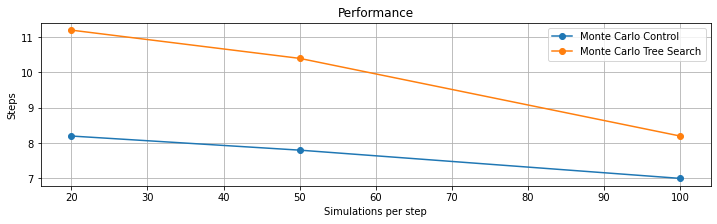

[[8.2, 7.8, 7.0], [11.2, 10.4, 8.2]]

In [16]:
# Uncomment to run the experiments (it takes around 6 minutes to run)

# problem={"taxi_pos":(0,0),"passenger_pos":(3,3),"domain_map":DEFAULT_MAP}
# plot_steps_per_simulations("mcc_vs_mcts.png", problem, ["Monte Carlo Control","Monte Carlo Tree Search"], [20,50,100], 5)

![mcc_vs_mcts](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/mcc_vs_mcts.png)

As we can see from the graph, Monte Carlo Control (MCC) outperforms Monte Carlo Tree Search (MCTS).

We relate it to the fact that **MCC** **uses a lot more data** than MCTS.

Indeed, while **MCTS** maintains the values **only** for nodes (state-action pairs) **in the tree**, **MCC** maintains a value **for each state-action pair it ever encountered** and thus it has access to more data.

This allows **MCC** to have a **better estimate** of the value of each state-action pair and therefore to have a better policy. However, this comes at the cost of **a lot more memory usage**.

On the other hand, **MCTS** is more **scalable** and can be used in problems where the state-action space is too big to fit in memory. This is the case of games like chess or Go. In fact, MCTS (with the extension that we're going to present in the next section, i.e. RAVE, and with neural networks) is the algorithm that allowed DeepMind to create AlphaGo, the first AI that was able to beat the world champion in Go. 

However, **MCTS** does **not always find the optimal policy**, as we have seen in this example.

Without further ado, let's take a look at an extension of Monte Carlo Tree Search called **Rapid Action Value Estimation** (RAVE).

# Rapid Action Value Estimation (RAVE)
- RAVE is a family of heuristics which created the first program to achieve dan (master) level in Go. [[Gelly, Silver 2011]](https://www.sciencedirect.com/science/article/pii/S000437021100052X)
- **MCTS** requires a **lot of simulations** to sample several pairs of state and action
- To **speed up** this estimate we can introduce a **bias**
- We will **update** the pair $\langle s, a \rangle$ **with** the **reward** obtained **using** $a$ **from** any state in the **subtree** of $s$ (AMAF heuristic)
![rave](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/rave.png)

RAVE shares the value of actions across subtrees of the search tree. 

It is in this way that **RAVE** forms a very **fast** and **rough**
estimate of the action value, whereas the value estimated by **Monte-Carlo Tree Search** is **slower** **but** more **accurate**.

It is possible to **combine** these two value estimates in a principled fashion

There are multiple ways to weight these two values. In particular, we will use **UCT-RAVE**

The value of a state-action pair is given by this combination:
$$
\tilde{Q}(s,a) = (1-\beta(s,a))*Q(s,a) + \beta(s,a)*RAVE(s,a)
$$
Where:
- $\tilde{Q}(s,a)$ is the  value attributed to the pair $\langle s, a \rangle$ which is called **MC-RAVE**
- $\beta(s,a)$ is a parameter which dynamically balances these two estimates
- $Q(s,a)$ is the average Q-value of $\langle s, a \rangle$
- $RAVE(s,a)$ is the RAVE value of $\langle s, a \rangle$

$$\beta(s,a) = \sqrt{\frac{k}{3N(s,a)+k}}$$
Where:
- $N(s,a)$ is the number of times that we visited the current node
- $k$ is an hyperparameter that sets the number of simulation at which $Q$ and $RAVE$ are given the same weight

![beta](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/beta.png)


In order to balance the exploration-exploitation trade-off, **UCT-RAVE** uses UCT by using $\tilde{Q}$ instead of $Q$.

In detail we will have:

$$
Q_{*}(s,a) = \tilde{Q}(s,a) + C \sqrt{\frac{\log(N(s))}{N(s,a)}} 
$$

Now we are going to implement UCT-RAVE.
In order to keep track of the action values taken in the subtree we will need to override several functions of the MonteCarloTreeSearchNode class.

We will highlight the biggest conceptual differences in the code.

In [13]:
class RAVEMonteCarloTreeSearchNode(MonteCarloTreeSearchNode):
    '''Introduce RAVE optimization to MCTS'''
    def __init__(self, state, n_simulations=100, parent=None, parent_action=None, k=3, gamma=0.78):
        super().__init__(state, n_simulations, parent,parent_action, gamma=gamma)
        self.average_reward_rave = 0
        self.number_of_visits_rave = 0
        self.k = k
        # We need to override the evaluate function to use the rave value in rendering
        self._evaluate_function = self._uct_rave

    def _best_action(self, render:bool=False):
        """
        Execute the four stages to find the best action from the current state.
        """
        for _ in range(self.n_simulations):
          node = self._tree_policy()
          reward, taken_actions = node._rollout()
          node._backpropagate(reward, taken_actions)
        if not render:
            return self._best_child(c_param=0.)
        else:
            return self._best_child(c_param=0.), self
    
    def _tree_policy(self):
      """
      Selects node to run rollout.
      """
      current_node = self
      while not current_node._is_terminal_node():

          if current_node._is_leaf():
              # Differently from what we did in Monte Carlo Tree Search, even if we do not select
              # a certain child from the current node, we still need to create it so that 
              # we will be able to update its rave value in the backpropagation step.
              current_node._create_all_children()
              return current_node._best_child()
          
          current_node = current_node._best_child()
      return current_node

    def _is_leaf(self):
        """
        Returns True if the node is a leaf node, False otherwise.
        """
        return len(self.children) == 0

    def _create_all_children(self):
        """
        Create all possible child nodes for the current node.
        """
        for action in self._untried_actions:
            
            new_state = deepcopy(self.state)
            new_state.step(action)
            obs, reward, done, trunc, info = new_state.last()
            child_node = RAVEMonteCarloTreeSearchNode(state = new_state, n_simulations=self.n_simulations,
                            parent=self, parent_action=action, k=self.k, gamma=self.gamma)
            child_node.terminal_state = done
            child_node.average_reward = reward
            child_node.number_of_visits = 1
            child_node.average_reward_rave = reward
            child_node.number_of_visits_rave = 1
            

            self.children.append(child_node)

    def _best_child(self, c_param=0.8):
        """
        Select the best child from the children array according to the MC-RAVE formula.
        :param c_param: Exploration parameter.
        :return: The child with the highest MC-RAVE value.
        """
        choices_weights = [self._uct_rave(child, c_param) for child in self.children] 
        return self.children[np.argmax(choices_weights)]

    def _uct_rave(self, child, c_param):
        """
        Returns the UCT-RAVE value for a child node.
        :param child: The child node for which the MC-RAVE value is calculated.
        :param c_param: Exploration parameter.
        :return: The UCT-RAVE value for the child node.
        """
        
        mc = float('inf') if child.number_of_visits == 0 else child.average_reward
        rave = float('inf') if child.number_of_visits_rave == 0 else child.average_reward_rave
        beta = np.sqrt(self.k / (3 * self.number_of_visits + self.k))
        # mc_rave value which combines the mc and the rave values:
        q_star = (1-beta)*mc + beta*rave
        uct_rave =  float('inf') if (child.number_of_visits == 0 or self.number_of_visits == 0) else q_star + \
        c_param*np.sqrt( \
            np.log(self.number_of_visits)/ child.number_of_visits \
            )
        return uct_rave

    def _rollout(self):
        """
        Conducts a rollout from the current node.
        :return: a tuple containing the reward obtained and the actions taken during the rollout.
        """
        current_rollout_state = deepcopy(self.state)

        _reward = 0
        step = 0
        done = current_rollout_state.last()[2]
        taken_actions = []
        while not done:
            possible_moves = self._get_legal_actions()

            action = self._rollout_policy(possible_moves)
            current_rollout_state.step(action)
            obs, reward, done, trunc, info = current_rollout_state.last()
            _reward += reward*(self.gamma**step)
            # DIFFERENCE FROM MONTE CARLO TREE SEARCH: we need to keep track of the actions taken
            taken_actions.append(action)
            ##############################
            step += 1
        return _reward, taken_actions

    def _backpropagate(self, reward, taken_actions):
        """
        Backpropagates the reward obtained during the rollout to the parents of the current node.
        :param reward: The reward obtained during the rollout.
        :param taken_actions: The actions taken during the rollout.
        """
        self.number_of_visits += 1
        self.average_reward = self.average_reward + (1/self.number_of_visits)*(reward-self.average_reward)

        # DIFFERENCE FROM MONTE CARLO TREE SEARCH: we need to update the rave estimates of the children
        for action in taken_actions:
            for child in self.children:
                if child.parent_action == action:
                    child._update_rave_estimate(reward)
        ###############################################
        
        if self.parent is not None:
            self.parent._backpropagate(reward, taken_actions)
    
    def _update_rave_estimate(self, reward):
        """
        Updates the rave estimate of the current node.
        :param reward: The reward obtained during the rollout.
        """
        self.number_of_visits_rave += 1
        self.average_reward_rave = self.average_reward_rave + (1/self.number_of_visits_rave)*(reward-self.average_reward_rave)


Now let's see RAVE in action.

In [14]:
env = new_environment_creator(taxi_pos=(0,0),passenger_pos=(3,3))
rave = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = 20, k=1, gamma=0.78)
rave.run_and_update(max_number_of_steps=1000, render=True)

Step number: 14
Action executed: pickup
Names: | Values: | Average reward: | Number of visits:
south| 0.657 | -1 | 1
north| 0.657 | -1 | 1
east| 0.657 | -1 | 1
west| 0.657 | -1 | 1
pickup| 8.133 | 1.356 | 73 <--
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 3), Engine: ON, Collided: False, Step: 14, ALIVE
Passenger0-YELLOW: Location: Taxi0 (3, 3), Destination: (-1, -1)
Env done: True



14

As we can see, despite having access to the **same** amount of **data** **as MCTS**, RAVE is able to learn a **better policy** than the one learned by MCTS.

This is due to the fact that RAVE is able to use the data in a **more efficient** way, by means of its **heuristic**.

To make a more rigorous comparison, we will evaluate each of the algorithms for a variety of simulations. We redefine evaluate_policy to executes one of the algorithms: "Monte Carlo Control", "Monte Carlo Tree Search", "RAVE" for any given of number of simulations.

In [15]:
def evaluate_policy(problem, algorithm, simulations, render:bool=True):
    if not algorithm in ["Monte Carlo Control", "Monte Carlo Tree Search", "RAVE"]:
        raise ValueError("Algorithm must be one among: Monte Carlo Control, Monte Carlo Tree Search, RAVE and NewRAVE")
      
    env = new_environment_creator(taxi_pos=problem["taxi_pos"], passenger_pos=problem["passenger_pos"],domain_map=problem["domain_map"])

    if algorithm == "Monte Carlo Control":
        # Monte Carlo Control
        monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_steps_per_episode=1_000)
        step = monte_carlo_control.run_and_update(number_of_simulated_episodes=simulations, render=render)
        return step

    elif (algorithm=="Monte Carlo Tree Search"):
        # Monte Carlo Tree Search
        mcts = MonteCarloTreeSearchNode(state = env, n_simulations=simulations, gamma=0.78)
        step = mcts.run_and_update(max_number_of_steps=1000, render=render)
        return step
    
    elif (algorithm =="RAVE"):
        # RAVE
        rave = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = simulations, k=1, gamma=0.78)
        step = rave.run_and_update(max_number_of_steps=1000, render=render)
        return step

Finally we plot the performance of the algorithms according to number of simulations.

P.S. By default render is set to False to make the notebook run faster. If you want to see the agent in action, set render to True.

Monte Carlo Control for 10 simulations
Monte Carlo Tree Search for 10 simulations
RAVE for 10 simulations
Monte Carlo Control for 20 simulations
Monte Carlo Tree Search for 20 simulations
RAVE for 20 simulations
Monte Carlo Control for 30 simulations
Monte Carlo Tree Search for 30 simulations
RAVE for 30 simulations
Monte Carlo Control for 50 simulations
Monte Carlo Tree Search for 50 simulations
RAVE for 50 simulations
Experiments' results:
[[7.0, 7.9, 7.4, 7.0], [18.5, 13.4, 9.4, 9.4], [18.9, 10.6, 9.6, 8.7]]


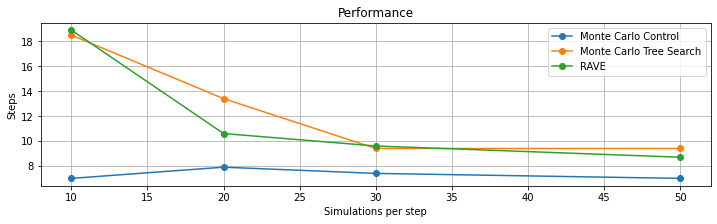

In [9]:
# Uncomment to execute the code (it takes around 16 minutes)

# problem={"taxi_pos":(0,0),"passenger_pos":(3,3),"domain_map":DEFAULT_MAP}
# results = plot_steps_per_simulations("new_comparison_mcc_vs_mcts_vs_rave.png", problem, ["Monte Carlo Control", "Monte Carlo Tree Search", "RAVE"],[10,20,30,50],10)

![comparison](https://raw.githubusercontent.com/GabrieleSerussi/mcts/main/new_comparison_mcc_vs_mcts_vs_rave.png)

Our previous hypothesis seems to be confirmed by the last plot.

In summary:
- **MCC** (Monte Carlo Control) is the **best** algorithm among these ones in terms of **performance** but it **requires** a **lot of data** to learn a good policy
- **MCTS** (Monte Carlo Tree Search) is **scalable** and can be used in problems where the state-action space is too big to fit in memory, but it **does not always find the optimal policy**
- **RAVE** (Rapid Action Value Estimation) is an **extension** of **MCTS** that **speeds up** the **learning** of the **action values** by **introducing a bias**. This leads to a **more efficient** **use of data** and to a **better policy** than the one learned by vanilla MCTS.

# TODO 1

In this exercise you will try to see how the algorithms behave in a harder problem.
In this case we will bring the passenger **farther** away from the taxi, so that the agent will need to take **more actions** to achieve the goal.

Please, follow the instructions below:

1. Define a problem with the passenger location = (5,4), the taxi location = (0,0) and the map = DEFAULT_MAP
2. Run plot_steps_per_simulations with this new problem for Monte Carlo Control, Monte Carlo Tree Search and RAVE with [10,20] simulations and 3 experiments
3. Compare the performance of the algorithms in this new problem

# TODO 2

In this exercise you will try to see how the algorithms behave in a bigger map. In this case, despite the taxi being as close to the passenger as before, the **map will be bigger** and thus the **Monte Carlo Simulations** are likely to be longer, more expensive and **noisier**.

Please, follow the instructions below:

1. Define a problem with the taxi location = (2,0), the passenger location = (3,3) and the map = BIG_MAP
2. Run plot_steps_per_simulations with this new problem for Monte Carlo Control, Monte Carlo Tree Search and RAVE with [10,30] simulations and 3 experiments
3. Compare the performance of the algorithms in this new problem

# TODO 3 (Optional)

In this exercise you will modify the way RAVE balances the two estimates. In particular you will need to modify the function with which we estimate the value of a node, so that the reliance on the RAVE value decays slower compared to what happens in RAVE with the same value of k.

Please, follow the instructions below:

1. Implement the TODO in the function _mc_rave of the class NewRAVENode
2. Define a problem with the taxi location = (0,0), the passenger location = (3,3) and the map = DEFAULT_MAP
3. Run plot_steps_per_simulations with this problem for NewRAVE with 20 simulations and 3 experiments
4. Compare the performance of NewRAVE with the performance of Monte Carlo Control and Monte Carlo Tree Search and RAVE

In [116]:
class NewRAVENode(RAVEMonteCarloTreeSearchNode):
    def __init__(self, state, n_simulations=100, parent=None, parent_action=None, k=3, gamma=0.78):
        super().__init__(state, n_simulations, parent,parent_action, k=k, gamma=gamma)
    
    def _uct_rave(self, child, c_param=0.8):
        """
        Returns the UCT-RAVE value for a child node.
        :param child: The child node for which the MC-RAVE value is calculated.
        :param c_param: Exploration parameter.
        :return: The UCT-RAVE value for the child node.
        """
        mc = float('inf') if child.number_of_visits == 0 else child.average_reward
        rave = float('inf') if child.number_of_visits_rave == 0 else child.average_reward_rave
        
        ##############################
        """
        TODO: modify beta so that the reliance on the RAVE value decays slower compared
            to what happens in RAVE with the same value of k.
            Hint: Can we replace the squared root with a different function?
        """
        beta = None
        ##############################
        q_star = (1-beta)*mc + beta*rave
        uct_rave =  float('inf') if (child.number_of_visits == 0 or self.number_of_visits == 0) else q_star + \
        c_param*np.sqrt( \
            np.log(self.number_of_visits)/ child.number_of_visits \
            )
        return uct_rave

Now we will extend evaluate_policy so that it will be able to evaluate also the NewRAVE algorithm.

In [117]:
def evaluate_policy(problem, algorithm, simulations, render:bool=False):
    if not algorithm in ["Monte Carlo Control", "Monte Carlo Tree Search", "RAVE", "NewRAVE"]:
        raise ValueError("Algorithm must be one among: Monte Carlo Control, Monte Carlo Tree Search, RAVE and NewRAVE")
      
    env = new_environment_creator(taxi_pos=problem["taxi_pos"], passenger_pos=problem["passenger_pos"],domain_map=problem["domain_map"])

    if algorithm == "Monte Carlo Control":
        # Monte Carlo Control
        monte_carlo_control = MonteCarloControl(env, gamma=0.99, max_steps_per_episode=1_000)
        step = monte_carlo_control.run_and_update(number_of_simulated_episodes=simulations, render=render)
        return step

    elif (algorithm=="Monte Carlo Tree Search"):
        # Monte Carlo Tree Search
        mcts = MonteCarloTreeSearchNode(state = env, n_simulations=simulations, gamma=0.78)
        step = mcts.run_and_update(max_number_of_steps=1000, render=render)
        return step
    
    elif (algorithm =="RAVE"):
        # RAVE
        rave = RAVEMonteCarloTreeSearchNode(state = env, n_simulations = simulations, k=1, gamma=0.78)
        step = rave.run_and_update(max_number_of_steps=1000, render=render)
        return step
    
    elif (algorithm =="NewRAVE"):
        # NewRAVE
        rave = NewRAVENode(state = env, n_simulations = simulations, k=1, gamma=0.78)
        step = rave.run_and_update(max_number_of_steps=1000, render=render)
        return step